# Using Lunar Craters to Detect Hazardous Objects

### Introduction

The Moon’s craters are a well-preserved historical record of asteroid impacts that dates back hundreds of millions of years. These craters not only give us information about the history of the Moon, but have the potential to give us useful data on the asteroids that caused them as well. Given the sheer number of smaller asteroids in the solar system and the difficulties that come with identifying them as they get smaller in diameter, there is a bit of uncertainty around the number of smaller near Earth asteroids in our solar system. Looking at the craters themselves could give us insight into the actual distribution of near Earth asteroids, and more specifically, what percentage of these asteroids are considered potentially hazardous to the Earth. The George E. Brown NEO (Near-Earth Object) Survey Act defines potentially hazardous asteroids as those over 140 meters in diameter (NASA JPL, 2007).

The Robbins Lunar Crater Database provides insight into the size and frequency distribution of craters across the surface of the Moon. It also provides scientists with information about the ellipticity and orientation of all craters greater than 1 km in diameter (Robbins 2018). Using crater data, we attempt to approximate the characteristics of the causal asteroids using scaling laws (Hughes et al., 2003; Melosh 1989). However, the size of the crater also depends on surface gravity, impact velocity, projectile and target density, and angle of impact. While the first can be known, the latter properties will have to be estimated based on known statistics including data from observed impacts and equations derived from simulations (Davison, 2022; Ivanov, 2002). In order to estimate the rate at which these impacts occur, we can use the calculated ages of lunar craters. This does introduce a bit of error into our work, as it gives us only an estimate of the lunar geological epoch in which the craters were formed. Additionally, Robbins discusses the role of secondary craters, which are caused by ejecta from larger impactors (Robbins, 2018). These craters may skew our data since many small craters could have been the result of one object, and we are seeking to find frequency of collision. With all of this in mind, we can proceed into the analytical portion of our paper.


### Methods
In order to estimate the frequency of >140m impactors, we narrowed down our crater data to only include craters within the lunar maria. Because we know the approximate age at which the lunar maria were formed, 3.1-3.9 billion years ago (Hiesinger et al., 2010) , we can use their formation as an interval marker for the timeline of impacts and calculate an annual impact rate. The dataset first used was filtered to remove craters <5 km, so this was replaced with a dataset that used the full range of crater diameters from the full Robbins database. Because the original Robbins database contains over one million craters, we first generated a random sample of the entire database for computational expediency. We used the `pandas.read_csv.sample` method with no repetitions to pull the random values from the dataset to ensure that distributions were maintained. This was done in a separate file called “random_data_sample.py”, which we have included for reference. The file “random_sample.csv” contains 200,000 data points taken randomly from the original Robbins database, the randomness will ensure the same distribution of crater sizes as the complete dataset. We verified that the distribution was consistent by first plotting the distribution from the entire database, and confirmed that the distribution was the same with the subset.

In [4]:
# Import and read a dataset from an external file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

craters = pd.read_csv("random_sample.csv", sep = ",")

print (craters[:5])

# check that smallest craters are included
print("Smallest crater diameter", min(craters.DIAM_CIRC_IMG), "m")

   Unnamed: 0    CRATER_ID  LAT_CIRC_IMG  LON_CIRC_IMG  LAT_ELLI_IMG  \
0      589673  06-1-063213       29.0353       85.6503       29.0352   
1      914182  08-1-096723       23.7191      111.0380       23.7198   
2      240659  02-1-137888       41.0149      202.9290       41.0149   
3      265455  02-1-168432       53.9046      257.6790       53.9070   
4      309828  03-1-043901      -15.4955      231.9830      -15.4955   

   LON_ELLI_IMG  DIAM_CIRC_IMG  DIAM_CIRC_SD_IMG  DIAM_ELLI_MAJOR_IMG  \
0       85.6503        2.35898          0.022925              2.39554   
1      111.0380        1.41487          0.039218              1.55272   
2      202.9290        1.50699          0.024127              1.58014   
3      257.6780        1.93349          0.039928              2.03137   
4      231.9830        1.42103          0.055357              1.51322   

   DIAM_ELLI_MINOR_IMG  ...  DIAM_ELLI_ANGLE_IMG  LAT_ELLI_SD_IMG  \
0              2.32730  ...             142.5720         0.

A Monte Carlo simulation was applied to generate possible impactors of various diameters, velocities, densities, and impact angles.  We wanted to find these distributions specifically because the scaling law relates the size of the crater to the size of the asteroid and makes use of all these values. The distributions were based on those of Matthias et al. and are shown below.

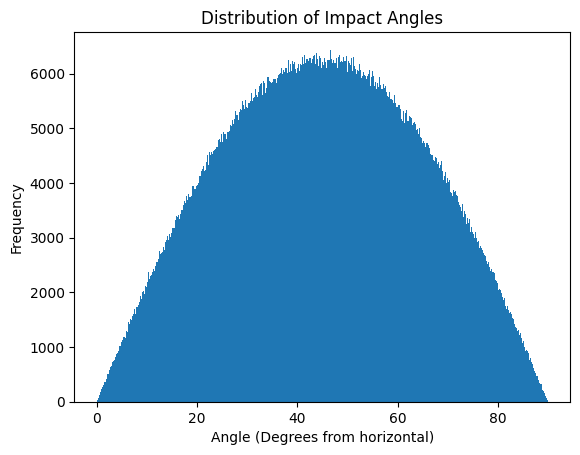

Min angle: 0.05
Max angle: 89.96


In [21]:
# generate random impact scenarios for Monte Carlo modeling
import random # importing the Python random library

angles=[] #declare list
for _ in range(2000000): # asking this to do stuff 2000000 times
    u=random.uniform(0,1) # random number between 0 and 1
    angle=(90/np.pi)*np.arccos(2*u-1) # Distribution of angles according to Mathias et al.
    angles.append(angle)

plt.hist(angles, bins=500)
plt.xlabel('Angle (Degrees from horizontal)')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Angles')
plt.show()

# Check that angles are reasonable
print('Min angle: %.2f' % min(angles))
print('Max angle: %.2f' % max(angles))

Figure 1: The simulated angles for the Monte Carlo model, will be converted to radians when implemented in the scaling equation.

In [6]:
# generate the distribution of densities according to Mathias et al.

asteroid_densities_g=[3.38,3.3,3.19,2.27,6.75,7.15,2.84,3.12,2.86] # densities of different asteroid types (g/cm3)
asteroid_densities=[density*1000 for density in asteroid_densities_g] # kg/m3
std_densities_g=[0.19,0.12,0.14,0.13,1.84,0.57,0.13,0.19,0.11]
std_densities=[sigma*1000 for sigma in std_densities_g] # kg/m3
fraction_of_total=[.349,.389,.093,.043,.025,.024,.034,.011,.034]
densities=[]
mu=np.mean(asteroid_densities_g)
sigma=np.std(asteroid_densities_g) 

for _ in range(2000000):
    density=random.normalvariate(2300,np.mean(std_densities)) # kg/m3
    densities.append(density)

Maximum velocity: 38664.85 m/s


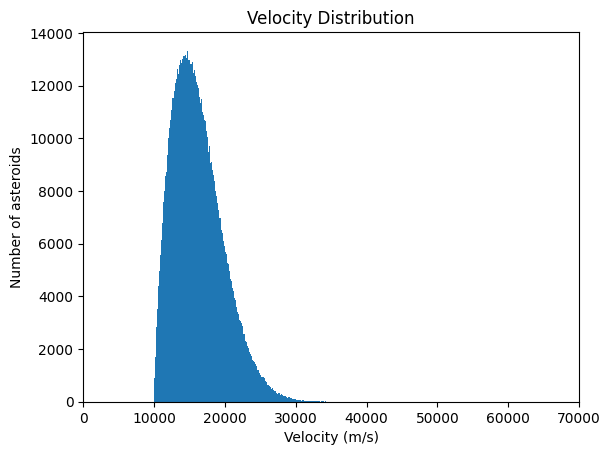

In [22]:
#generate distribution of velocities

velocities=[] # Velocities in m/s
for _ in range(2000000):
	velocity=(10*random.weibullvariate(.7, 1.8)+10)*1000 #convert to m/s
	velocities.append(velocity)
# Let's check that this looks correct.
plt.hist(velocities,bins=500) #again we'll check the results to make sure they make sense
plt.xlabel("Velocity (m/s)") 
plt.ylabel("Number of asteroids")
plt.title('Velocity Distribution')
plt.xlim(0,70000)
print("Maximum velocity:",'%.2f' %max(velocities),"m/s")


Figure 2: The distribution of simulated velocities, based on Matthias et al.

For the density distribution, the densest asteroids were excluded so as to simplify our distribution. This allowed us to remove the tail of the distribution and hence use a random weibull generation. Asteroids over 3500 kg/m3 make up only 2.9% of asteroids (Matthias et al., 2017), so we consider this a reasonable distribution.

Max density: 4204.46 kg/m3
Min density: 294.57 kg/m3


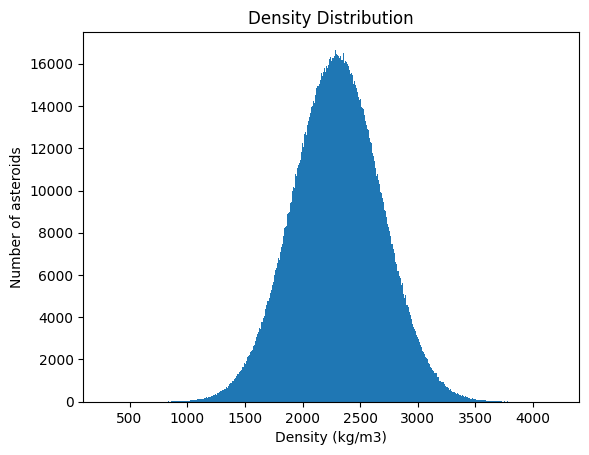

In [23]:
plt.hist(densities, bins=500)
plt.xlabel('Density (kg/m3)')
plt.ylabel('Number of asteroids')
plt.title('Density Distribution')
print('Max density: %.2f' % max(densities), 'kg/m3')
print('Min density: %.2f' % min(densities), 'kg/m3')


Figure 3: The distribution of densities, based on Matthias et al., but with the tail of lower densities removed for simplicity.

The randomly generated parameters combine to represent simulated asteroids. Craters whose sizes fall within the range of crater sizes for asteroids larger than 140m can then be ascertained.

In order to relate the craters in the database to the sizes of the asteroids that made them, a scaling law (Melosh, 1989) was used that relates the crater size, asteroid density, Moon density, asteroid velocity, acceleration of gravity at the Moon’s surface, and the angle of impact. The scaling law is represented by the equation 

$D_{tc}=1.161(\frac{\rho_p}{\rho_t})L^{0.78}v_i^{0.44}g^{-0.22}sin^{1/3}(\theta)$ 

where $D_{tc}$ is the crater diameter, $\rho_p$ is the projectile density, $\rho_t$ is the target density, $L$ is the asteroid diameter, $v_i$ is the impact velocity, $g$ is the acceleration of gravity on the Moon, and $\theta$ is the angle of impact. 


##### Locating Craters in the Maria
To narrow the time range of the dataset, we next had to filter the dataset into the craters inside the maria, with each of their locations and boundary regions approximated using the coordinates of the center of each mare (Hiesinger et al.). Because the maria are the youngest regions of the lunar surface, examining these allows us to learn about the most recent epoch in lunar history, which is more relevant to the present. Other parts of the lunar surface are also more difficult to date, and the higher incidence of overlapping craters would result in less accurate estimates of cratering rates. The mare’s outline was approximated as a circle for the sake of simplicity. An inscribed square was then created within that circle, providing minimum and maximum latitudes and longitudes. This area served as our observation area for simplicity of code and better ensure that we did not include any craters that are outside of the non-abstracted area of the mare. 


In [9]:
def find_craters_in_maria(center_lat,center_lon, half_diameter):
    """
    Check if specified crater is inside the circumference of the maria

    ARGS:
        center_lat: latitude of the center of the maria (degrees)
        center_lon: longitude of the center of the maria (degrees)
        half_diameter: distance (km) from the center of the mare to the edge of inscribed square
    OUTPUTS:
        filtered_craters: A dataset containing the crater ID, center latitude, 
        center longitude, and diameter (in km) of the craters found within the mare

    """
    craters = pd.read_csv("random_sample.csv", sep = ",")
    #The following lines calculate the bounds of the box we are observing
    max_long=center_lon+half_diameter
    min_long=center_lon-half_diameter
    max_lat=center_lat+half_diameter
    min_lat=center_lat-half_diameter


    #drop zero values
    craters_clean = craters[(craters!=0).all(axis=1)]

    #drop missing values
    craters_clean.dropna()
    
    #Filter out Longitudes out of our observation area
    filtered_craters=craters_clean[(craters_clean["LON_CIRC_IMG"] >= min_long) & (craters_clean["LON_CIRC_IMG"] <= max_long)]
    #Filter out Latitudes out of our observation area
    filtered_craters=filtered_craters[(filtered_craters["LAT_CIRC_IMG"] >= min_lat) & (filtered_craters["LAT_CIRC_IMG"] <= max_lat)]
    #drop columns we're not examining
    drop = ["DIAM_CIRC_SD_IMG", "DIAM_ELLI_MAJOR_IMG",
            "DIAM_ELLI_MINOR_IMG", "DIAM_ELLI_ECCEN_IMG", "DIAM_ELLI_ELLIP_IMG",
            "DIAM_ELLI_ANGLE_IMG", "LAT_ELLI_SD_IMG", "LON_ELLI_SD_IMG",
            "LON_ELLI_SD_IMG", "DIAM_ELLI_MAJOR_SD_IMG", "DIAM_ELLI_MINOR_SD_IMG",
            "DIAM_ELLI_ECCEN_SD_IMG", "DIAM_ELLI_ELLIP_SD_IMG",
            "DIAM_ELLI_ANGLE_SD_IMG", "ARC_IMG", "PTS_RIM_IMG", "LAT_ELLI_IMG", "LON_ELLI_IMG", "DIAM_CIRC_SD_IMG", "DIAM_ELLI_MAJOR_IMG"]

    filtered_craters.drop(drop, inplace=True, axis=1)

    return filtered_craters

#### Finding Craters in Maria
All asteroids with center coordinates within this square were included in the dataset of craters in the maria. This filtered dataset was then combined with the simulated asteroids to extract craters that were likely created by asteroids greater than 140m. A preview of the diameter distribution of these craters is shown below.


In [10]:
# Load IAU data with mare locations, rename columns
maria=pd.read_csv("mare_locations.csv", sep = ",", header=0, names=['FEATURE_NAME','TARGET','DIAMETER','CENTER_LAT','CENTER_LON','COORD_SYST','APPROVAL_STATUS','APPROVAL_DATE','ORIGIN'])

crater_list=pd.DataFrame() # Craters in the maria
for mare in range(len(maria)):
        # Find all craters likely caused by asteroids >140m
    half_distance_km= maria.DIAMETER[mare]/2 #This distance is the number of kilometers you would need to travel from the center of the mare to the side of an inscribed rectangle within it
    half_distance_degrees=half_distance_km/30.323350424146458 #Convert to degrees
    center_long=maria.CENTER_LON[mare]   #This is the longitude coordinate of the center of the mare
    center_lat=maria.CENTER_LAT[mare] #This is the latitude coordinate of the center of the mare
    found_craters=find_craters_in_maria(center_lat,center_long,half_distance_degrees)
    crater_list=pd.concat([crater_list,found_craters])

crater_list.head(10)

,Unnamed: 0,CRATER_ID,LAT_CIRC_IMG,LON_CIRC_IMG,DIAM_CIRC_IMG
195,560946,06-1-002479,20.3123,67.1590,1.36318
10310,579968,06-1-046063,20.7780,69.4629,2.93597
12387,560934,06-1-002465,21.8473,65.4503,1.07882
18017,634909,06-2-009425,23.8312,68.4126,4.61853
18423,581817,06-1-049185,22.5497,68.9738,1.55610
19673,581827,06-1-049203,23.3541,69.8791,1.22138
21846,582609,06-1-050357,23.3419,67.6162,1.09944
28260,644698,06-3-034364,20.6238,65.2417,1.06757
39105,579953,06-1-046044,20.5100,68.2990,2.05494
39481,582625,06-1-050391,23.6281,66.9618,1.30595


(0.0, 17500.0)

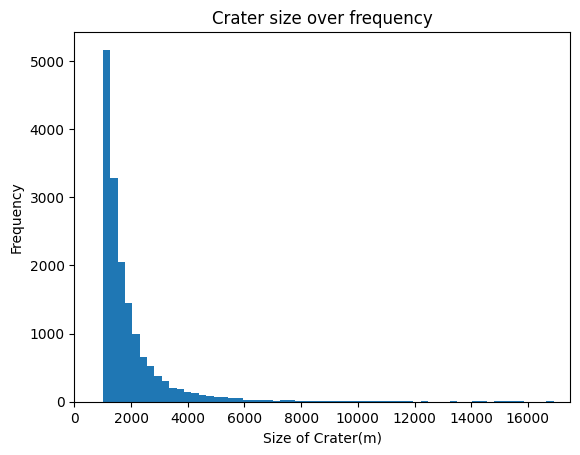

In [24]:
# Check the distribution of crater diameters for craters in the maria

import matplotlib.pyplot as plt
import matplotlib
crater_diams_m=[crater_diam*1000 for crater_diam in crater_list["DIAM_CIRC_IMG"]] # convert crater diameter to m
plt.hist(crater_diams_m, bins=2500)
plt.title("Crater size over frequency")
plt.xlabel("Size of Crater(m)") 
plt.ylabel("Frequency")
plt.xlim(0,17500)

#### Crater Size to Asteroid Size
The original scaling law solves for crater size, so the equation was rearranged to also solve for asteroid diameter based on the actual craters sizes from our database. The distributions found earlier were then input into the equation to find all of the craters that could have been made by asteroids larger than 140 meters in the dataset. We achieve this by assigning each real crater to a random velocity, impact angle, and density from the Monte Carlo simulation. In using the actual crater data, we are treating the crater diameters as another set of “random” values to complete the Monte Carlo simulation.


In [12]:
actual_crater_diameters=crater_diams_m # m
rand_densities=densities[:len(actual_crater_diameters)] # kg/m3
rand_velocities=velocities[:len(actual_crater_diameters)] # m/s
rand_angles=angles[:len(actual_crater_diameters)] # degrees

rho_t = 2550 #Density of (moon) target (kg/m^3)
g = 1.625 #surface gravity (m/s^2)


predicted_asteroid_diam=[] # Asteroid diameters based on the random crater characteristics and Robbins crater diameters

for crater, crater_diam in enumerate(actual_crater_diameters):
    
    D_tc = crater_diam # Crater diameter at level of ground surface (m)
    rho_p = rand_densities[crater]  # Density of asteroid (projectile)(kg/m^3)
    v_i = rand_velocities[crater] # impact velocity (m/s)
    theta = rand_angles[crater] # impact angle, referencing from horizontal (rad)

    a = (1.161*(rho_p/rho_t)**(1/3))
    b = (v_i**(0.44))
    c = (g**(-0.22))
    d = (math.sin(math.radians(theta))**(1/3))


    predicted_diam=(D_tc/(a*b*c*d))**(1/0.78)
    predicted_asteroid_diam.append(predicted_diam)
 
print('smallest asteroid %.2f' % min(predicted_asteroid_diam),'m')
print('smallest crater %.2f' % (min(actual_crater_diameters)),'m')

smallest asteroid 20.04 m
smallest crater 1000.06 m


#### Asteroid to Crater Size
Because we are interested in finding the crater sizes of asteroids of 140 meters and larger, we must solve for the smallest possible simulated crater diameter. We do this by rearranging the equation above, where we solve for asteroid diameter, in order to solve for the crater diameter of an asteroid that is exactly 140 m. We then simulate 1000 craters from the 140m asteroid to get an average and standard deviation of the lower limit of crater size.


In [19]:
# Find range of crater sizes for an asteroid of exactly 140m

actual_asteroid_diameter= 140 # m
rand_densities=densities[:1000]
rand_velocities=velocities[:1000]
rand_angles=angles[:1000]

rho_t = 2550 #Density of (moon) target (kg/m^3)
g = 1.625 #surface gravity (m/s^2)


predicted_crater_diam=[]

for i in range(len(rand_densities)):
    rho_p = rand_densities[i]  # Density of asteroid (projectile)(kg/m^3)
    v_i = rand_velocities[i] # impact velocity (m/s)
    theta = rand_angles[i] # impact angle, referencing from horizontal (rad)
    L=actual_asteroid_diameter

    a = (1.161*(rho_p/rho_t)**(1/3))
    b = (v_i**(0.44))
    c = (g**(-0.22))
    d = (math.sin(math.radians(theta))**(1/3))
    e=(L**(0.78))


    D_tc=a*b*c*d*e
    predicted_crater_diam.append(D_tc)

mean_crater_size_140 = np.mean(predicted_crater_diam)
crater_standard_deviation_140 = np.std(predicted_crater_diam)

max_possible=max(predicted_crater_diam)
min_possible=min(predicted_crater_diam)
print('max', max_possible)
print('min', min_possible)
print('mean crater size from 140m asteroids %.2f' % mean_crater_size_140)
print('standard deviation crater size from 140m asteroids %.2f' % crater_standard_deviation_140, 'm')
print('standard deviation as a percentage %.2f' % (100*crater_standard_deviation_140/mean_crater_size_140))

max 4360.34811939936
min 762.6224930152322
mean crater size from 140m asteroids 2903.31
standard deviation crater size from 140m asteroids 527.41 m
standard deviation as a percentage 18.17


## Results and Analysis

The results of the simulation of asteroids based on the Monte Carlo model and crater diameter data are plotted below (Figure 1).


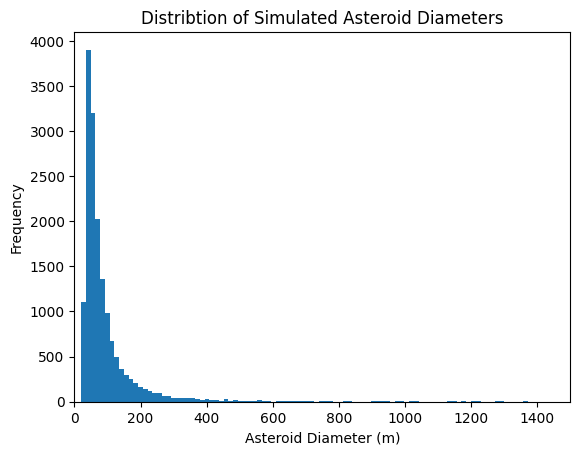

In [25]:
plt.hist(predicted_asteroid_diam, bins=10000)
plt.xlim(0,1500)
plt.title("Distribtion of Simulated Asteroid Diameters")
plt.xlabel("Asteroid Diameter (m)")
plt.ylabel('Frequency')
plt.show()

Figure 4: The distribution of crater sizes based on the Monte Carlo simulation.

Based on the generated list of asteroid diameters, we extract the asteroids that are over 140 m. The result is 2448, or 14.99% of the 200,000 simulated asteroids. The mean crater diameter from an asteroid of 140 m was found to be 2888.11 m with a standard deviation of +-513.51 m or 17.78%. The age of the maria is estimated to be 3.5 billion years, +- 0.4 billion years (Heisinger et al., 2010). Dividing the number of large craters by the age of the maria yields an approximate impact rate of 699 impacts every billion years.

In [15]:
# print(max(predicted_asteroid_diam))

big_count=0
big_diams=[]
for asteroid in predicted_asteroid_diam:
    if asteroid >= 140:
        big_diams.append(predicted_asteroid_diam)
        big_count+=1

# Get important numbers
maria_age=3.5 # average age (billions of years) +- 0.4 billion
print('Number of >140 m asteroids:', big_count)
print('Percentage of simulated asteroids: %.2f' % (100*big_count/len(predicted_asteroid_diam)))
print('Impact rate of >140m asteroids: %.2f' % (big_count/maria_age), 'impacts/1 billion yrs')

Number of >140 m asteroids: 2462
Percentage of simulated asteroids: 15.08
Impact rate of >140m asteroids: 703.43 impacts/1 billion yrs


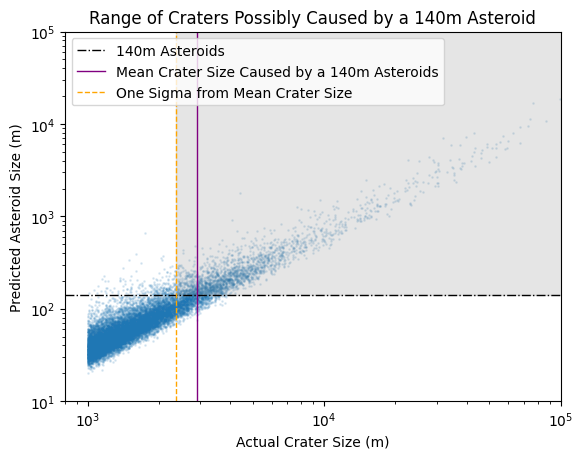

In [32]:
plt.scatter(actual_crater_diameters,predicted_asteroid_diam,s=1,alpha=.12)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Crater Size (m)')
plt.ylabel('Predicted Asteroid Size (m)')
plt.title('Range of Craters Possibly Caused by a 140m Asteroid')
plt.axhline(140, color='black', linewidth=1, ls = 'dashdot', label='140m Asteroids')
plt.axvline(mean_crater_size_140, color='purple', linewidth=1, label='Mean Crater Size Caused by a 140m Asteroids')
plt.axvline(mean_crater_size_140-crater_standard_deviation_140, color='orange', ls = '--', linewidth=1, label='One Sigma from Mean Crater Size')
plt.xlim(800,10**5)
plt.ylim(10,10**5)

x = np.linspace(mean_crater_size_140-crater_standard_deviation_140,1000000)# np.array([mean_crater_size_140-crater_standard_deviation_140, max(actual_crater_diameters)])
y1 = 140
y2=140+1000000
plt.fill_between(x, y1, y2, color='Gray', alpha=0.2)
plt.legend(loc = 'upper left')


Figure 5: Out of the asteroids simulated from the synthesis of the actual craters from the Robbins database and probable impactor characteristics, approximately 15%  fell into the range of possible >140m asteroids. Over time, this represents an impact rate of 699 impacts every 1 billion years. The shaded region highlights all the asteroids that are possibly caused by >140m asteroids within 1 standard deviation (+- 513 m or 17.78%).


#### Sources of Error
The certainty of the impact rate is limited by the certainty of the maria dating. Different maria have different estimated ages, with an error of +-0.4 billion years.

The Monte Carlo modeling technique has a margin of error embedded in it, but in order to quantify that, we would need to compare it to a real life experimental distribution for each of the characteristics we measured. 

Another source of error comes from abstracting the maria into squares inscribed into a circle of its diameter. Any samples taken from maria that are more elliptical or teardrop shaped could result in an area outside of the mare (more densely packed with craters) to be included in our data set. In the future this could be solved by getting more exact coordinates for the outlines of each maria using GIS data. This would be achievable given there are only 22 maria that we are sampling from.


## Conclusion
Determining the size of an asteroid given the craters formed by it is a difficult task, but provides us a good estimate for the proportion of potentially hazardous near Earth asteroids. Findings by other people are scattered, because different databases of asteroids have different classifications for small asteroids they are taking into account. NASA data indicates that about 38 percent of known near-Earth objects are above 100 m, however, we know there is a large number of as yet unidentified smaller NEOs (Discovery Statistics). The actual percentage of large asteroids is therefore much smaller. This makes it difficult to validate our model, but also shows the value of using cratering data to learn about the size distributions of NEOs. Our hope is that this model could be used in future cases to describe the possible characteristics of impactors given a crater database. If future space observation yields new crater databases, this model could be applied to different situations such as alternate planets, regions of the Moon, or groups of asteroids. This can help scientists assess the risk of catastrophic collisions. This data could be used to project the frequency of large asteroid impact onto the Earth. There are factors that can scale the number of impacts on the Moon to the number of impacts on the Earth, which could have a direct influence on peoples' lives. 


#### Works cited

Discovery Statistics., https://cneos.jpl.nasa.gov/stats/size.html

H. Hiesinger, J. Head III, U. Wolf, R. Jaumann, G. Neukum, Ages and stratigraphy of lunar mare basalts in Mare Frigoris and other nearside maria based on crater size-frequency distribution measurements. J. Geophys. Res. Planets 115, E03003 (2010).

Hughes, D. W. 2003, Monthly Notices of the Royal Astronomical Society, 338, 999

Ivanov, B. A., & Artemieva, N. A. 2002, in Catastrophic events and mass extinctions: impacts and beyond (Geological Society of America)

Mathias, D. L., Wheeler, L. F., & Dotson, J. L. 2017, Icarus, 289, 106

Melosh, H. J. 2011, Planetary Surface Processes (1st ed.; Cambridge University Press)

NASA’s Moon Data Sheds Light on Earth’s Asteroid Impact History - NASA Science.

NEO Survey and Deflection Analysis and Alternatives., https://cneos.jpl.nasa.gov/doc/neo_report2007.html
